In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

m, n = data.shape
print(m, n)
data_test_size = 1000/m
print(data_test_size)

# Separate features and labels
X = data.iloc[:, 1:].values  # pixel values
Y = data.iloc[:, 0].values   # labels (0-9)

# Normalize pixel values to be between 0 and 1
X = X / 255.0

# Convert data to torch tensors
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.long)

# Split into training and development sets
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=data_test_size, random_state=42)

# Create DataLoader for batching
train_data = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

dev_data = TensorDataset(X_dev, Y_dev)
dev_loader = DataLoader(dev_data, batch_size=128, shuffle=False)

42000 785
0.023809523809523808


In [2]:
# Custom initializers
def custom_initializer_1(layer):
    if isinstance(layer, nn.Linear):
        nn.init.uniform_(layer.weight, -0.5, 0.5)
        nn.init.uniform_(layer.bias, -0.5, 0.5)

def custom_initializer_2(layer):
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, mean=0.0, std=4/(784+10))
        nn.init.zeros_(layer.bias)

# New model architecture
class SimpleNN(nn.Module):
    def __init__(self, initializer=None):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)

        # Apply the custom initializer if provided
        if initializer is not None:
            initializer(self.fc1)
            initializer(self.fc2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Training loop
def train_model(model, train_loader, dev_loader, epochs=50, learning_rate=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_acc_history = []
    dev_acc_history = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            running_loss += loss.item()

        train_acc = 100 * correct / total
        train_acc_history.append(train_acc)

        # Evaluate on development set
        model.eval()
        dev_correct, dev_total = 0, 0
        with torch.no_grad():
            for dev_x, dev_y in dev_loader:
                dev_outputs = model(dev_x)
                _, dev_predicted = torch.max(dev_outputs, 1)
                dev_total += dev_y.size(0)
                dev_correct += (dev_predicted == dev_y).sum().item()

        dev_acc = 100 * dev_correct / dev_total
        dev_acc_history.append(dev_acc)

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%, Dev Accuracy: {dev_acc:.2f}%')

    return train_acc_history, dev_acc_history

Training model with Initializer 1 (Uniform)
Epoch 1/50, Loss: 1.0380, Train Accuracy: 65.04%, Dev Accuracy: 80.50%
Epoch 2/50, Loss: 0.5017, Train Accuracy: 84.14%, Dev Accuracy: 86.50%
Epoch 3/50, Loss: 0.4100, Train Accuracy: 87.42%, Dev Accuracy: 88.00%
Epoch 4/50, Loss: 0.3675, Train Accuracy: 88.89%, Dev Accuracy: 89.80%
Epoch 5/50, Loss: 0.3429, Train Accuracy: 89.62%, Dev Accuracy: 89.70%
Epoch 6/50, Loss: 0.3249, Train Accuracy: 90.36%, Dev Accuracy: 90.60%
Epoch 7/50, Loss: 0.3114, Train Accuracy: 90.65%, Dev Accuracy: 89.00%
Epoch 8/50, Loss: 0.3006, Train Accuracy: 91.03%, Dev Accuracy: 90.30%
Epoch 9/50, Loss: 0.2929, Train Accuracy: 91.16%, Dev Accuracy: 89.90%
Epoch 10/50, Loss: 0.2861, Train Accuracy: 91.41%, Dev Accuracy: 91.60%
Epoch 11/50, Loss: 0.2779, Train Accuracy: 91.59%, Dev Accuracy: 92.30%
Epoch 12/50, Loss: 0.2727, Train Accuracy: 91.83%, Dev Accuracy: 92.10%
Epoch 13/50, Loss: 0.2679, Train Accuracy: 92.02%, Dev Accuracy: 92.20%
Epoch 14/50, Loss: 0.2636, Tr

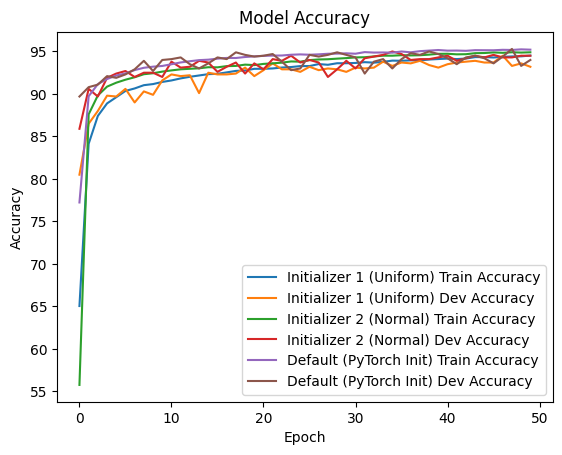

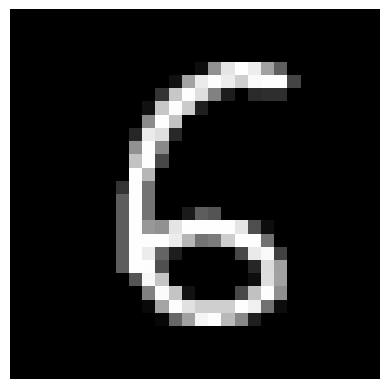

Prediction: 6, True Label: 6


In [4]:
# Plotting function for accuracy
def plot_history(train_accs, dev_accs, names):
    for i, name in enumerate(names):
        plt.plot(train_accs[i], label=f'{name} Train Accuracy')
        plt.plot(dev_accs[i], label=f'{name} Dev Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Train and evaluate with both custom initializations and default PyTorch initialization
initializers = {
    'Initializer 1 (Uniform)': custom_initializer_1,
    'Initializer 2 (Normal)': custom_initializer_2,
    'Default (PyTorch Init)': None
}

train_accs = []
dev_accs = []

for name, initializer in initializers.items():
    print(f"Training model with {name}")
    
    # Build model with the current initializer
    model = SimpleNN(initializer)
    
    # Train the model
    train_acc, dev_acc = train_model(model, train_loader, dev_loader)
    
    # Store results for plotting
    train_accs.append(train_acc)
    dev_accs.append(dev_acc)

# Plot all accuracies
plot_history(train_accs, dev_accs, initializers.keys())

# Predict a sample and visualize
index = 5  # Pick a sample index
current_image = X_dev[index].reshape(28, 28).numpy()  # Reshape from 784 to 28x28

# Display the image
plt.imshow(current_image, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

# Make a prediction with the last trained model (using last initializer)
model.eval()
sample = X_dev[index].reshape(1, 784)
prediction = torch.argmax(model(sample)).item()
true_label = Y_dev[index].item()

print(f"Prediction: {prediction}, True Label: {true_label}")